## Композиции моделей: бэггинг, случайный лес

Будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). 

In [4]:
from collections import Counter
from typing import Dict, List, Tuple, Union
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [42]:
data_temp = pd.read_csv('diabetes.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [7]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

In [8]:
data['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [44]:
X = data_temp.drop('Outcome', axis = 1)

<Axes: >

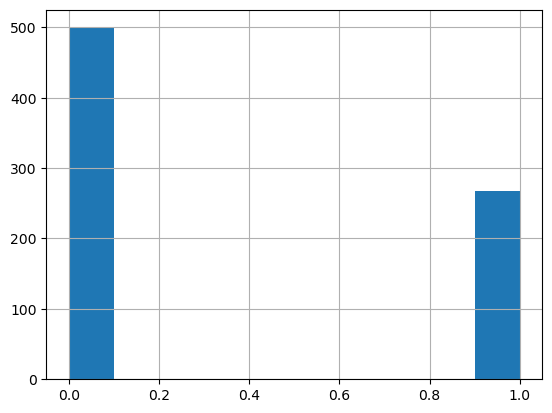

In [9]:
data['Outcome'].hist()

Разделите данные на признаки и целевую переменную. Разбейте датасет на тренировочную и тестовую части в отношении 70:30.

✅ Разделим данные на признаки и целевую переменную

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
scaler = StandardScaler()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Outcome', axis = 1),
                                                    data['Outcome'], random_state = 0, test_size = 0.3, stratify = data['Outcome'])

In [ ]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

✅ Обучите BaggingClassifier на 50 деревьях. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

*Создадим функцию для подсчета метрик:*

In [22]:
def calc_all_metrics(y_pred, y_test):
    return (f'Accuracy: {accuracy_score(y_test, y_pred)}\n'
           f'Precision: {precision_score(y_test, y_pred)}\n'
           f'Recall: {recall_score(y_test, y_pred)}\n'
            f'AUC-ROC: {roc_auc_score(y_test, y_pred)}\n')

**BaggingClassifier**

In [23]:
bagging_clf = BaggingClassifier(n_estimators = 50)

bagging_clf.fit(X_train, y_train)
y_pred_bagging = bagging_clf.predict(X_test)

print(f'Bagging Classifier:\n{calc_all_metrics(y_pred_bagging, y_test)}')

Bagging Classifier:
Accuracy: 0.7445887445887446
Precision: 0.6617647058823529
Recall: 0.5555555555555556
AUC-ROC: 0.7011111111111111



✅ Теперь обучите Random Forest с таким же количеством деревьев. Оцените качество классификации по тем же метрикам. Какая из двух построенных моделей показала себя лучше?

**Random Forest**

In [24]:
rand_forest_clf = RandomForestClassifier(n_estimators = 50)

rand_forest_clf.fit(X_train, y_train)
y_pred_rand_forest = rand_forest_clf.predict(X_test)

print(f'randforest Classifier:\n{calc_all_metrics(y_pred_rand_forest, y_test)}')

randforest Classifier:
Accuracy: 0.7878787878787878
Precision: 0.7285714285714285
Recall: 0.6296296296296297
AUC-ROC: 0.7514814814814815



✅ Какая из двух построенных моделей показала себя лучше?

In [25]:
np.sum(y_pred_bagging == y_pred_rand_forest)/len(y_pred_rand_forest)

0.9047619047619048

**Заметим, что модели выдают очень похожие предсказания.**

✅ Для случайного леса проанализируйте значение AUC-ROC на этих же данных в зависимости от изменения параметров:
* `'n_estimators'` 
* `'min_samples_leaf'`

Постройте соответствующие графики зависимости AUC-ROC от этих параметров. Используйте heat map для визуализации. Какие выводы вы можете сделать?

Строим графики зависимости AUC-ROC

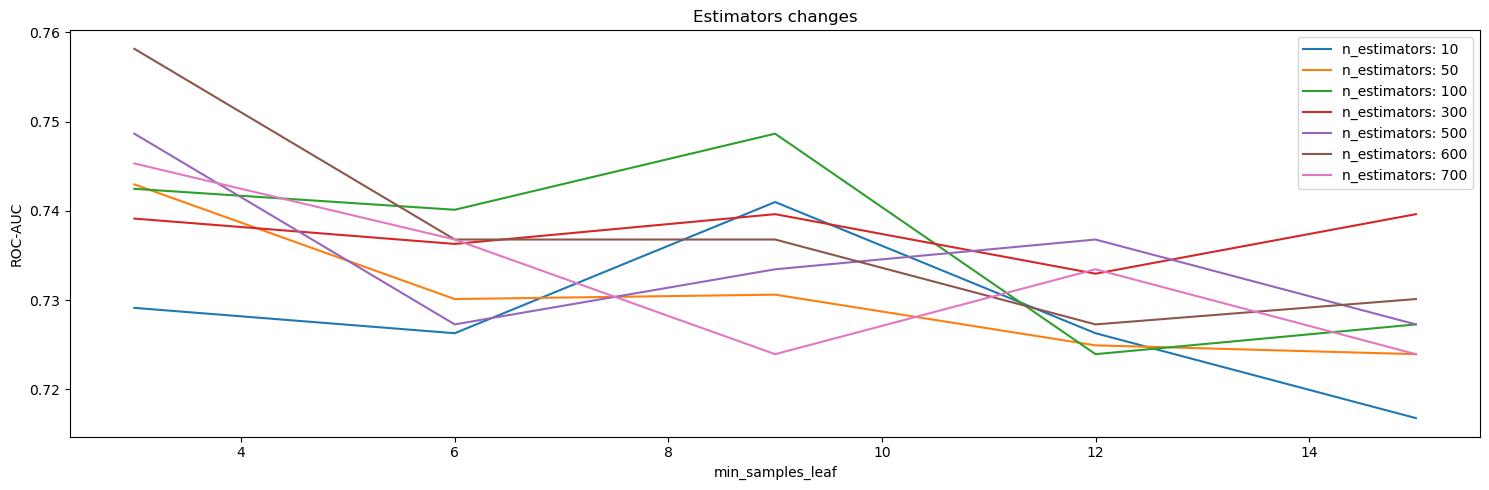

In [27]:
fig, ax1 = plt.subplots(figsize = (15, 5))

n_trees = [10, 50, 100, 300, 500, 600, 700]
leafes = [3, 6, 9, 12, 15]

for i in n_trees:
    score = []
    for j in leafes:
        rand_forest_clf = RandomForestClassifier(n_estimators = i, min_samples_leaf = j)
        
        rand_forest_clf.fit(X_train, y_train)
        y_pred_rand_forest = rand_forest_clf.predict(X_test)
        
        score.append(roc_auc_score(y_test, y_pred_rand_forest))
    ax1.plot(leafes, score)
    
ax1.set(xlabel = 'min_samples_leaf', ylabel = 'ROC-AUC', title = 'Estimators changes')
ax1.legend([f'n_estimators: {x}' for x in n_trees], loc = 'upper right')

plt.tight_layout()        

Строим тепловую карту 

*Строить тепловую карту удобнее, если использовать поиск по сетке.*

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
estimators = [10, 50, 100, 300]

min_samples_leaf = [3, 6, 9, 12, 15]

grid_values = {'n_estimators': estimators, 'min_samples_leaf': min_samples_leaf}

clf = GridSearchCV(RandomForestClassifier(), grid_values, scoring = 'roc_auc', cv = 3)
clf.fit(X_train, y_train)

best_n_estimators_value = clf.best_params_['n_estimators']
best_min_samples_leaf = clf.best_params_['min_samples_leaf']
best_score = clf.best_score_

In [30]:
print('Оптимальное количество деревьев', best_n_estimators_value)
print('Оптимальное количество листьев', best_min_samples_leaf)
print('AUC-ROC', best_score)

Оптимальное количество деревьев 300
Оптимальное количество листьев 12
AUC-ROC 0.8242337730658087


(Преобразовываем для построения тепловой карты)

In [31]:
estimators = clf.cv_results_['param_n_estimators'].data

In [33]:
min_samples_leaf = clf.cv_results_['param_min_samples_leaf'].data

In [34]:
sns.set_style('white')
plt.figure(figsize =(7, 5))

data = pd.DataFrame(data = {'Estimators': estimators, "Min_samples leaf": min_samples_leaf,
                            "AUC": clf.cv_results_['mean_test_score']})


<Figure size 700x500 with 0 Axes>

In [37]:
data = data.pivot(index = 'Estimators', columns = 'Min_samples leaf', values = 'AUC')

Text(0.5, 1.0, 'AUC for test data')

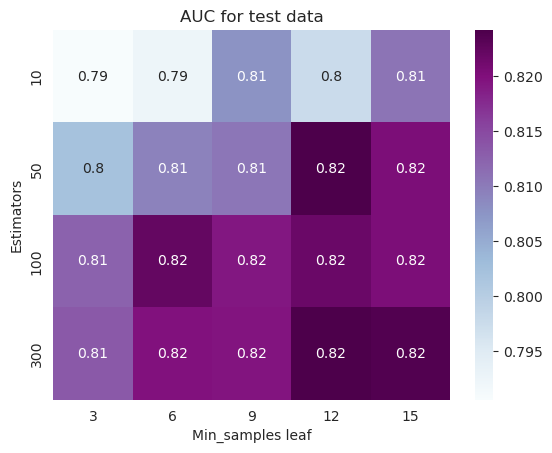

In [38]:
sns.heatmap(data, annot = True, cmap = "BuPu").set_title("AUC for test data")

✅ Для лучшей модели случайного леса посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [39]:
#Обучим лучшую модель
rand_forest_clf = RandomForestClassifier(n_estimators = 300, min_samples_leaf = 12, random_state = 0)

rand_forest_clf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=12, n_estimators=300, random_state=0)

In [40]:
importances = rand_forest_clf.feature_importances_

In [45]:
features = pd.DataFrame({"feature": X.columns, 'importance': importances})

In [46]:
features

,feature,importance
0,Pregnancies,0.068089
1,Glucose,0.355535
2,BloodPressure,0.047583
3,SkinThickness,0.052381
4,Insulin,0.055658
5,BMI,0.144261
6,DiabetesPedigreeFunction,0.087288
7,Age,0.189205


In [53]:
features.sort_values(by = 'importance', ascending = False)

,feature,importance
1,Glucose,0.355535
7,Age,0.189205
5,BMI,0.144261
6,DiabetesPedigreeFunction,0.087288
0,Pregnancies,0.068089
4,Insulin,0.055658
3,SkinThickness,0.052381
2,BloodPressure,0.047583


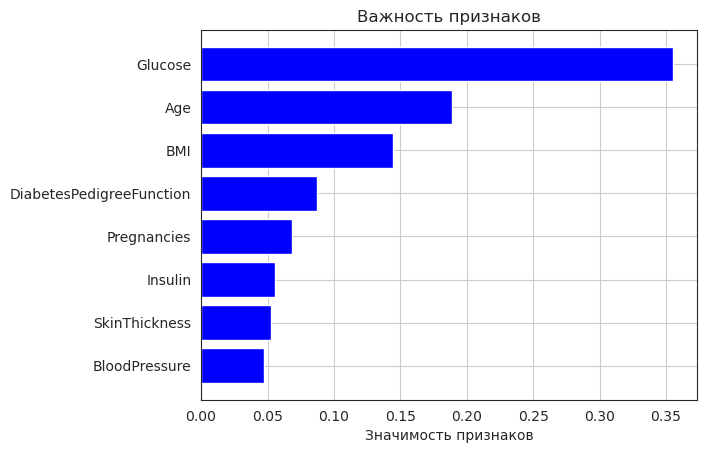

In [56]:
indices = np.argsort(importances)
columns = data_temp.columns[:-1]  # Исключаем целевой столбец

plt.figure()
plt.title("Важность признаков")

plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), columns[indices])
plt.xlabel('Значимость признаков')
plt.grid(True)
plt.show()
